In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import geopandas as gpd
import pandas as pd
# from geopy.distance import geodesic
# import seaborn as sns
import warnings
import shapely
import time
import cartopy.crs as ccrs
%matplotlib inline
mpl.rcParams['lines.linewidth'] = 1
mpl.rcParams['lines.linestyle'] = '--'
mpl.rcParams["figure.figsize"] = [8,8]
mpl.rcParams['lines.markersize'] = 5

In [2]:
daily_gauges = gpd.read_file("Contour Data/Daily-Gauges-UK.shp",crs=4326)
hourly_gauges = gpd.read_file("Contour Data/Hourly-Gauges-UK.shp",crs=4326)

#### Merge all hourly and dialy gauges still recording for the MET office in 2020

In [3]:
gauges = hourly_gauges.append(daily_gauges)

C:\Users\david\AppData\Local\Temp\ipykernel_11844\4224330975.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gauges = hourly_gauges.append(daily_gauges)


In [4]:
gauges.src_id.count()

368

### Code to load different grid part

In [5]:
def bulk_import_shapefiles(file_prefix="ny",n=2,file_type="point"):
    """
    Allows  easy import of shapefiles, use the format as shown in the function.
    Returns two lists: one lst of the geopandas dataframe, other the centres of each grid.
    """
    lst_files = []
    lst_grid = []
    for i in range(n+1):
        # add prefix 0 to single digits
#         print(i,end="\r")
        if i < 10:
            index = f"0{i}"
        else:
            index = i
        try:
            # define path name
            filename = f"Contour Data/Contours/{file_prefix}/{file_prefix.upper()}{index}_{file_type}.shp"
            with open(filename):
                pass
            # read file
            shapefile = gpd.read_file(filename)
            shapefile.to_crs(epsg=4326,inplace=True)
            if file_type == "point":
                # indexing code to later find which shapefile we want per gauge: this is with centroids
                warnings.simplefilter("ignore")
                lst_grid.append(shapefile.dissolve().centroid[0])
            ## Inefficient Code
#             if file_type is None:
#                 # indexing code to later find which shapefile we want per gauge: this is with the bounds of the contours
#                 boundaries = shapefile.dissolve().bounds.to_numpy()[0]
#                 lst_grid.append(Point((boundaries[0] + boundaries[2])/2,(boundaries[1] + boundaries[3])/2))
                
            
            # append the df to a list
            lst_files.append(shapefile)
            
        # NY31 doesn't exsist so we do it this way to deal with it
        except FileNotFoundError:
            lst_files.append(None)
            lst_grid.append(None)
#             print(f"Missing:{filename}")
            pass
    # finally return it 
    return lst_files,lst_grid

In [6]:
def select_closest_grid(gauge):
    """
    Takes the grid refference closest to the gauge and returns that index.
    """
    lst_distances = []
    for i in lst_grid_point:
        if i is None:
            lst_distances.append(np.inf)
        else:
            lst_distances.append(i.distance(gauge))
    closest = min(lst_distances)
    return lst_distances.index(closest)

def select_closest_dist(gauge):
    """
    Takes the grid refference closest to the gauge and returns the distance.
    """
    lst_distances = []
    for i in lst_grid_point:
        if i is None:
            lst_distances.append(np.inf)
        else:
            lst_distances.append(i.distance(gauge))
    closest = min(lst_distances)*10**5
    return closest

def select_closest_diff(gauge):
    """
    Takes the grid refference closest to the gauge and returns the distance.
    """
    lst_distances = []
    for i in lst_grid_point:
        if i is None:
            lst_distances.append(np.inf)
        else:
            lst_distances.append(i.distance(gauge))
    closest1 = min(lst_distances)*10**5
    for i in lst_grid_point:
        if i is None:
            lst_distances.append(np.inf)
        else:
            lst_distances.append(i.distance(gauge))
    closest2 = min(lst_distances)*10**5
    return closest

In [7]:
def plot_station(index=0, annotate=False):
    station = gauges_in_cell.iloc[index]
#     base = plt.axes(projection=ccrs.PlateCarree())
    base = lst_points[station.grid_id].plot(label= "Spot Heights",color="blue", alpha = 0.6)
    plt.plot(station.station_lo,station.station_la,"ro",label=f"{station.station_na} weather station")
    lst_lines[station.grid_id].plot(ax=base,alpha =0.1)
    plt.title(f"Distance to gridcell center:{station.grid_id_distance/1000:.3f}km ")
    plt.legend(bbox_to_anchor=(1, -0.05))
    if annotate:
        height = lst_points[station.grid_id].PROP_VALUE.to_numpy()
        x = lst_points[station.grid_id].geometry.x.to_numpy()
        y = lst_points[station.grid_id].geometry.y.to_numpy()
        for i, txt in enumerate(height):
            base.annotate(txt,(x[i],y[i]),label="Height above mean sea-level")

In [8]:
def get_df_per_station(index=0):
    """
    Insert index of the gauges df and returns spotheights and contour dfs
    """
    station = gauges_in_cell.iloc[index]
    spot_heights = lst_points[station.grid_id]
    contour_lines = lst_lines[station.grid_id]
    return spot_heights, contour_lines

In [9]:
def select_closest_contour(gauge_id=0):
    """
    Takes gauge_id and returns df sorted by proximity of their centroids
    """
    ### station needs to be defined
    station = gauges_in_cell.iloc[gauge_id]
    def distance_to_gauge(df):
        """Calculates distance to given station and adds to df column"""
        return df.distance(station.geometry)
    
    spot_heights, contourlines = get_df_per_station(gauge_id)
    contourlines['distance_to_gauge'] = contourlines.geometry.apply(distance_to_gauge)*10**5
    return contourlines.sort_values('distance_to_gauge')


In [10]:
def distance_to_n_contours(index=0,selected_n=10):
    """
    Repeats select_closest_contour() but for index of df, returns new df
    """
    contours = select_closest_contour(index).head(selected_n)
    point = gauges_in_cell.iloc[index].geometry
    distance_contour = []
    for i in range(selected_n):
        line = contours.iloc[i].geometry
        distance_contour.append(point.distance(line.interpolate(line.project(point)))*10**5)
    return contours

In [11]:
def closest_point_on_contour(index=0,selected_n=10):
        contours = select_closest_contour(index).head(selected_n)
        rain_gauge = gauges_in_cell.iloc[index].geometry
        
        def point_on_contour(line):
            """finds point on contour used to project and  adds to df column"""
            return line.interpolate(line.project(rain_gauge))
    
        contours["point_on_contour"] = contours.geometry.apply(point_on_contour)
        
        return contours

In [12]:
def plot_closest_point_contours(index=0, annotate=False, spot_heights=False, distances=False, selected_n=10):
    """
    Plots the given data till now
    """
    
    #calls main df and extracts needed data
    station = gauges_in_cell.iloc[index]
    base = select_closest_contour(index).head(selected_n).plot(alpha =0.5)
    plt.plot(station.station_lo,station.station_la,"ro",label=f"{station.station_na} weather station")
    
    # adding the distance as title
    if distances:
        line = select_closest_contour(index).head(selected_n).iloc[0].geometry
        point = gauges_in_cell.iloc[index].geometry
        distance_contour=point.distance(line.interpolate(line.project(point)))*10**5
        plt.title(f"Distance to closest contour: {distance_contour:.3f}m ")
    
    
    # plots spot heigts as wel as 
    if spot_heights:
        lst_points[station.grid_id].plot(ax=base, label= "contour_points",color="blue")
        
    # adds centroids and points on the contours
    if annotate:
        height = lst_points[station.grid_id].PROP_VALUE.to_numpy()
        x = lst_points[station.grid_id].geometry.x.to_numpy()
        y = lst_points[station.grid_id].geometry.y.to_numpy()
        for i, txt in enumerate(height):
            base.annotate(txt,(x[i],y[i]))
        height = lst_lines[station.grid_id].PROP_VALUE.to_numpy()
        
    # adds centroids and points on the contours    
    if selected_n < 31:
        select_closest_contour(index).head(selected_n).centroid.plot(ax=base,label="centroid",color="green")
        closest_point_on_contour(index).point_on_contour.plot(ax=base,label="Closest points on contours",color="purple")
    plt.legend(bbox_to_anchor=(1, -0.05))
    
    # returns for more plotting after
    return base

In [13]:
def sorted_distance_between_points_on_contours(index=0, selected_n=10):
    contour = closest_point_on_contour(index,selected_n)
    points = contour.point_on_contour.to_numpy()
    distance = []
    for i in range(len(points)):
        if i == len(points) - 1:
            pass
        else:
            distance.append(round(points[i].distance(points[i+1])*10**5))
    return distance

In [14]:
def resorted_points_on_contours(index=0, selected_n=10):
    contour = closest_point_on_contour(index,selected_n)
    points = list(contour.point_on_contour.to_numpy())
    
    # start with the furthest Node
    current_node = contour.point_on_contour.iloc[selected_n-1]
    
    # add this to the list of current nodes
    index_chosen_points = [selected_n-1]
    chosen_points = [current_node]
    chosen_distances = []
    
    # and remove the node from out list, replacing it with none to preserve indexing
    points[selected_n-1] = None
    
    #run untill 1 ellement left 
    while len(index_chosen_points) < len(points):
        
        # create a new list to store distances
        lst_distance = []
        
        # loop over all points
        for i in points:
            # check its not already chosen
            if i is not None:
                # caculate distance from current to all others
                lst_distance.append(round(current_node.distance(i)*10**5))
            else:
                # again preserving indexes
                lst_distance.append(np.inf)
        
        # take the minimum of the caculated nodes and find the index
        closest = min(lst_distance)
        # print(lst_distance)
        new_index = lst_distance.index(closest)
        
        # reassign new node and remove the current_node from the points list
        current_node = contour.point_on_contour.iloc[selected_n-1]
        points[new_index] = None
        
        # add this index to the selected list
        index_chosen_points.append(new_index)
        chosen_points.append(current_node)
        chosen_distances.append(round(closest))
        
    return chosen_distances

In [41]:
def sorted_slope_steepness(index):
    """
    rise / run * 100%
    rise = 50m per contour
    run  = computed distance
    Takes averages and then turn into slope
    """
    d = sorted_distance_between_points_on_contours(index)
    return round((50 * 100) /(sum(d)/len(d)),2)

def sorted_slope_steepness_method2(index):
    """
    Turns into slope and then averages
    """
    d = sorted_distance_between_points_on_contours(index)
    lst = []
    for i in d:
        if i > 0:
            lst.append(50 / i * 100)
    return sum(lst)/len(lst)

def resorted_slope_steepness(index):
    """
    Takes averages and then turn into slope
    """
    d = resorted_points_on_contours(index)
    return round((50 * 100) /(sum(d)/len(d)),2)

def resorted_slope_steepness_method2(index):
    """
    Turns into slope and then averages
    """
    d = resorted_points_on_contours(index)
    lst = []
    for i in d:
        if i > 0:
            lst.append(50 / i * 100)
    return sum(lst)/len(lst)


In [42]:
gridnames = []
with open("Final Data Output/gridnames.csv") as fin:
    for line in fin:
        gridnames.append(line.strip())
# gridnames

In [45]:
start = time.time()
run = True
if run:
    for i, grid_id in enumerate(gridnames):
        print(i,end="\r")
        lst_points, lst_grid_point = bulk_import_shapefiles(grid_id, 99,"point")
        lst_lines, empty_list = bulk_import_shapefiles(grid_id, 99,"line")

        gauges["grid_id"] = gauges.geometry.apply(select_closest_grid)
        gauges["grid_id_distance"] = gauges.geometry.apply(select_closest_dist)

        gauges_in_cell = gauges.query("grid_id_distance < 5000")
        gauges_in_cell.reset_index(inplace=True)
        gauges_in_cell.reset_index(inplace=True)
        gauges_in_cell

        gauges_in_cell["Slope_sorted"] = gauges_in_cell.level_0.apply(sorted_slope_steepness)
        gauges_in_cell["Slope_resorted"] = gauges_in_cell.level_0.apply(resorted_slope_steepness)
#         gauges_in_cell["Slope_sorted2"] = gauges_in_cell.level_0.apply(sorted_slope_steepness_method2)
#         gauges_in_cell["Slope_resorted2"] = gauges_in_cell.level_0.apply(resorted_slope_steepness_method2)

        gauges_in_cell.to_csv(f"Output/{grid_id}.csv",
                              columns=["src_id","Slope_sorted","Slope_resorted"]) #,"Slope_sorted2","Slope_resorted2"])

    end = time.time()
    print(f'{(end - start)/60:.3f} min')

14.981 min


In [86]:
i = "hx"

# col = [1,2,3,4,5]
col = [1,2,3]
base = pd.read_csv("Output/" + i + ".csv",index_col=0,usecols=col)
for i in gridnames:
    base = base.append(pd.read_csv("Output/" + i + ".csv",usecols=col))
    warnings.simplefilter("ignore")
    
gauges.src_id = gauges.src_id.astype(int)
base.src_id = base.src_id.astype(int)
# for i in ["Slope_resorted","Slope_sorted2","Slope_resorted2","Slope_sorted"]: 
#     base[i] = base[i].astype(float)

In [88]:
base = base.sort_values("src_id")
base

,Slope_resorted,src_id,Slope_sorted
0,27.24,3,43.44
0,8.32,9,11.57
0,7.3,12,8.99
0,4.33,23,12.69
0,11.44,32,8.94
...,...,...,...
5,7.75,62004,7.95
5,6.98,62015,6.76
6,3.16,62031,4.52
6,5.63,62039,13.01


In [89]:
combined = pd.merge(gauges, base,on="src_id")
# combined.to_csv("Final Data Output/206 stations with slope Data.csv")
combined

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance,Slope_resorted,Slope_sorted
0,3,FAIR ISLE,fair-isle,shetland,59.526,-1.630,57,1974,2020,POINT (-1.63000 59.52600),49,8.923866e+05,27.24,43.44
1,9,LERWICK,lerwick,shetland,60.139,-1.185,82,1930,2020,POINT (-1.18500 60.13900),49,9.455311e+05,8.32,11.57
2,12,BALTASOUND NO 2,baltasound-no-2,shetland,60.748,-0.856,15,1990,2020,POINT (-0.85600 60.74800),49,1.002230e+06,7.3,8.99
3,23,KIRKWALL,kirkwall,orkney,58.953,-2.901,26,1957,2020,POINT (-2.90100 58.95300),49,8.714545e+05,4.33,12.69
4,32,WICK AIRPORT,wick-airport,caithness,58.454,-3.090,36,1930,2020,POINT (-3.09000 58.45400),49,8.318475e+05,11.44,8.94
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
200,56423,"MIDDLETON, HILLSIDE",middleton-hillside,derbyshire,53.099,-1.589,295,2009,2020,POINT (-1.58900 53.09900),49,2.875691e+05,13.32,45.23
201,7621,LINKENHOLT POST OFFICE,linkenholt-post-office,hampshire,51.320,-1.479,197,2013,2020,POINT (-1.47900 51.32000),49,1.671327e+05,6.66,14.32
202,24219,MANNINGTON HALL,mannington-hall,norfolk,52.844,1.179,30,1999,2020,POINT (1.17900 52.84400),69,2.259978e+05,2.99,2.8
203,57118,BUTE: ROTHESAY NO2,bute-rothesay-no2,buteshire,55.825,-5.056,36,2013,2020,POINT (-5.05600 55.82500),49,7.219455e+05,6.23,9.05


In [90]:
combined.Slope_sorted.max(),combined.Slope_sorted.min(), combined.Slope_sorted.mean(),

(154.64, 2.38, 15.861804878048787)

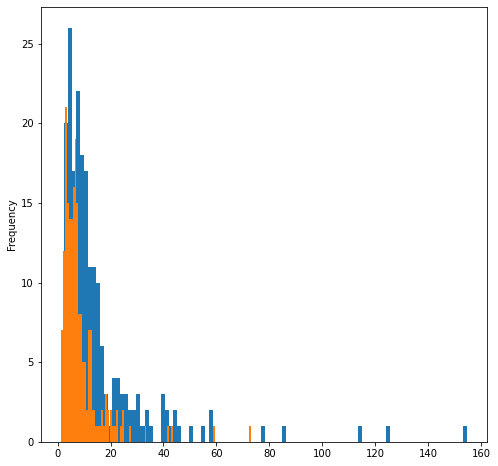

In [91]:
combined.Slope_sorted.plot.hist(bins=100)
combined.Slope_resorted.plot.hist(bins=100);


Text(0, 0.5, 'Steepness (%)')

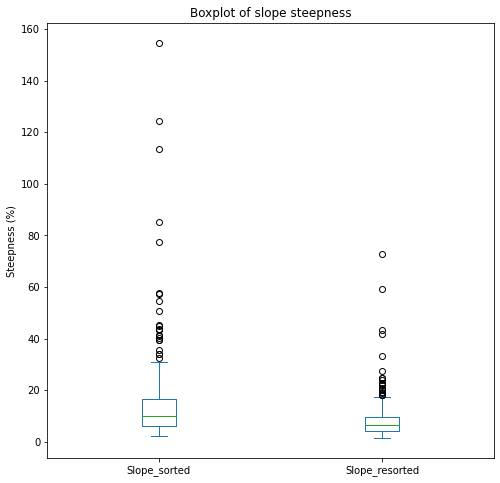

In [92]:
pd.DataFrame(combined, columns=["Slope_sorted","Slope_resorted"]).astype(float).plot.box()
plt.title("Boxplot of slope steepness")
plt.ylabel("Steepness (%)")
# plt.savefig("Plots/Slopesteepness Boxplot sorted vs resorted.jpg",pad_inches=0)

<AxesSubplot:>

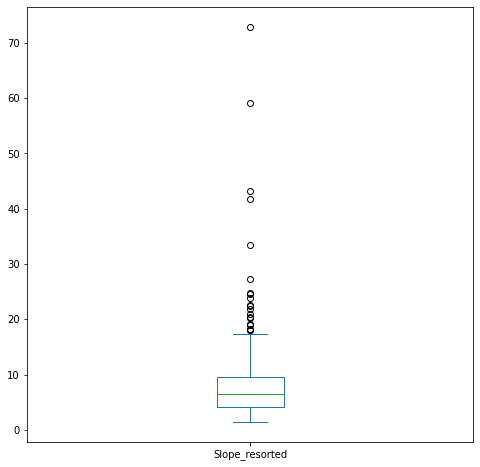

In [93]:
combined.Slope_resorted.plot.box()
# plt.savefig("Plots/Slopesteepness Boxplot resorted.jpg",pad_inches=0)

#### Saving queries for reprocessing

In [94]:
combined.query("Slope_resorted < 18.125").to_csv("Final Data Output/Removed outliers.csv")

In [95]:
combined.query("Slope_resorted < 18.125").head(1)

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance,Slope_resorted,Slope_sorted
1,9,LERWICK,lerwick,shetland,60.139,-1.185,82,1930,2020,POINT (-1.18500 60.13900),49,945531.063939,8.32,11.57


In [96]:
combined.query("Slope_resorted > 18.125").to_csv("Final Data Output//outliers.csv")

In [97]:
combined.query("Slope_resorted > 18.125").head()

,src_id,station_na,station_fi,historic_c,station_la,station_lo,station_el,first_year,last_year,geometry,grid_id,grid_id_distance,Slope_resorted,Slope_sorted
0,3,FAIR ISLE,fair-isle,shetland,59.526,-1.630,57,1974,2020,POINT (-1.63000 59.52600),49,892386.585136,27.24,43.44
17,177,INVERBERVIE NO 2,inverbervie-no-2,kincardineshire,56.852,-2.266,134,1992,2020,POINT (-2.26600 56.85200),49,652461.615683,20.47,26.19
18,195,TYNDRUM NO 3,tyndrum-no-3,perthshire-in-central-region,56.419,-4.661,168,1999,2020,POINT (-4.66100 56.41900),49,738648.004056,19.04,40.04
54,634,PENNERLEY,pennerley,shropshire,52.590,-2.950,357,2010,2020,POINT (-2.95000 52.59000),49,355079.778427,24.66,25.11
68,876,WIGHT: ST CATHERINES POINT,wight-st-catherines-point,isle-of-wight,50.576,-1.297,20,1982,2020,POINT (-1.29700 50.57600),49,141031.430327,22.39,44.91


#### Looking at outliers

In [98]:
IQR = combined.Slope_resorted.quantile(q=0.75) - combined.Slope_resorted.quantile(q=0.25)
Outlier_threshold = combined.Slope_resorted.quantile(q=0.75) + 1.5 * IQR
print(Outlier_threshold)
outliers_resorted = combined.query(f"Slope_resorted > {Outlier_threshold}")
print(outliers_resorted.src_id .count())
# outliers_resorted.plot.scatter(outliers_resorted.station_el,outliers_resorted.Slope_resorted)

17.965000000000003
20


<AxesSubplot:>

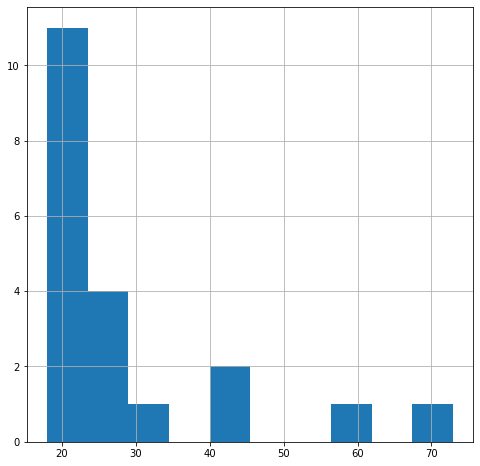

In [99]:
outliers_resorted.Slope_resorted.hist()

In [100]:
### recalculating for the fair isles (midterm figure)
grid_id = "hz"
run = False
if run:
    lst_points, lst_grid_point = bulk_import_shapefiles(grid_id, 99,"point")
    lst_lines, empty_list = bulk_import_shapefiles(grid_id, 99,"line")

    gauges["grid_id"] = gauges.geometry.apply(select_closest_grid)
    gauges["grid_id_distance"] = gauges.geometry.apply(select_closest_dist)

    gauges_in_cell = gauges.query("grid_id_distance < 5000")

    gauges_in_cell.reset_index(inplace=True)
    gauges_in_cell.reset_index(inplace=True)
    gauges_in_cell.drop(columns="index",inplace=True)

    gauges_in_cell["Slope_sorted"] = gauges_in_cell.level_0.apply(sorted_slope_steepness)
    gauges_in_cell["Slope_resorted"] = gauges_in_cell.level_0.apply(resorted_slope_steepness)

<AxesSubplot:>

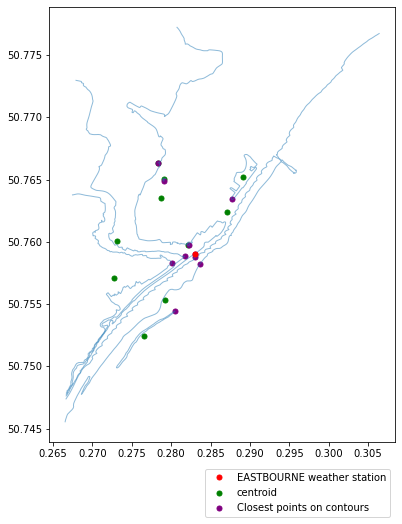

In [101]:
plot_closest_point_contours()
# plt.savefig("Plots/FairIsle weather station - 10 closest.jpg")

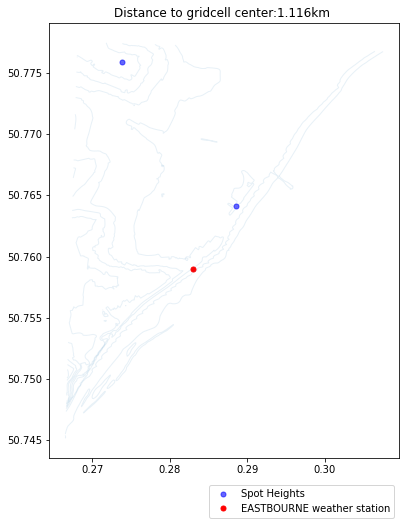

In [102]:
plot_station(0)
# plt.savefig("Plots/FairIsle weather station - overview.jpg")